# INVENTORY HEALTH MONITOR FOR AUTOMOTIVE STOCK

**Author:** Diane Haiden
**Date:** September 2025
**GitHub Repo:** [haidendr/supply-chain-kpi](https://github.com/haidendr/supply-chain-kpi)  
**License:** MIT License  

This Jupyter Notebook analyzes dealership inventory data to simulate reorder logic and calculate key supply chain KPIs, including:
- Days of Supply  
- Inventory Turnover  
- Stockout Risk  
- Forecasted Inventory Depletion  

**Data Source**: [FourFront Cars for Sale Dataset](https://www.fourfront.us/data/datasets/cars-for-sale-database-sample/)  
**File Used**: `Car_data.xlsx`

Feel free to **copy, adapt, or build upon** this notebook with attribution.

---
## Step 1: Import Libraries and Load Data

We use:
- `pandas` for data manipulation
- `matplotlib.pyplot` and `seaborn` for visualization

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

file_path = 'Car_data.xlsx'
inventory_df = pd.read_excel(file_path, sheet_name='InventoryPrice')
dealer_df = pd.read_excel(file_path, sheet_name='dealer')

inventory_df.head()
dealer_df.head()

,dealer,id,vin,mileage,stock,type,year,make,model,trim,...,price,bodystyle,fueltype,msrp,date_in_stock,pulldate,onlot,updated,dealerid,updateCnt
0,Sheridan Ford (Wilmington),21577,3FTTW8A30SRA79739,0,T25129,New,2025,Ford,Maverick,XL,...,27418,Trucks,Gas/Electric Hybrid,28690,2025-05-03,2025-06-19 12:52:00,1,2025-06-19 12:52:00,34,1
1,Sheridan Ford (Wilmington),21578,3FTTW8A39SRA95602,0,T25167,New,2025,Ford,Maverick,XL,...,28602,Trucks,Gas/Electric Hybrid,29940,2025-06-09,2025-06-19 12:52:00,1,2025-06-19 12:52:00,34,1
2,Sheridan Ford (Wilmington),21579,1FMCU9GN7SUA46889,0,T25044,New,2025,Ford,Escape,Activeâ„¢,...,28733,SUVs,Gasoline,32385,2024-12-21,2025-06-19 12:52:00,1,2025-06-19 12:52:00,34,1
3,Sheridan Ford (Wilmington),21580,1FMCU9GN7SUA34757,0,T25035,New,2025,Ford,Escape,Activeâ„¢,...,28733,SUVs,Gasoline,32385,2024-12-11,2025-06-19 12:52:00,1,2025-06-19 12:52:00,34,1
4,Sheridan Ford (Wilmington),21581,1FMCU9GN4SUA33839,0,T25021,New,2025,Ford,Escape,Activeâ„¢,...,28733,SUVs,Gasoline,32385,2024-11-20,2025-06-19 12:52:00,1,2025-06-19 12:52:00,34,1


---
## Step 2: Clean and Prepare Data

Here we standardize column names, clean currency formatting, and convert date fields for analysis.

In [14]:
# Inventory data cleanup
inventory_df.columns = inventory_df.columns.str.strip().str.upper().str.replace(' ', '_')
inventory_df['AVG_SALE_PRICE'] = inventory_df['AVG_SALE_PRICE'].replace(r'[\$,]', '', regex=True).astype(float)

# Dealer data cleanup
dealer_df.columns = dealer_df.columns.str.strip().str.lower().str.replace(' ', '_')
dealer_df['date_in_stock'] = pd.to_datetime(dealer_df['date_in_stock'], errors='coerce')
dealer_df['pulldate'] = pd.to_datetime(dealer_df['pulldate'], errors='coerce')
dealer_df['days_on_lot'] = (dealer_df['pulldate'] - dealer_df['date_in_stock']).dt.days

---
## Step 3: Merge Dealer Insights with Inventory

We calculate average days on lot per model and merge it with the inventory data.

In [15]:
avg_days_df = dealer_df.groupby(['make', 'model'])['days_on_lot'].mean().reset_index()
avg_days_df.rename(columns={'days_on_lot': 'avg_days_on_lot'}, inplace=True)

inventory_df.columns = inventory_df.columns.str.strip().str.lower()
avg_days_df.columns = avg_days_df.columns.str.strip().str.lower()

inventory_df = inventory_df.merge(avg_days_df, on=['make', 'model'], how='left')
inventory_df['days_of_supply'] = inventory_df['inventory_total'] / (30 / inventory_df['avg_days_on_lot'])

---
## Step 4: Visualize Inventory Levels by Model

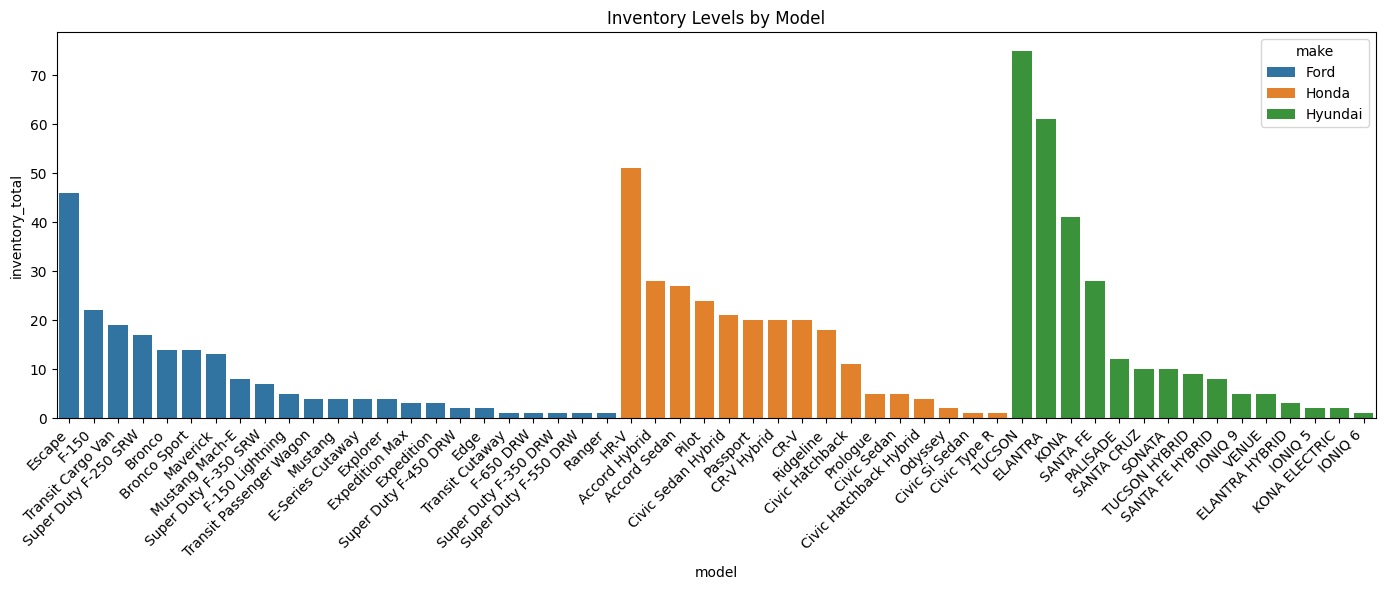

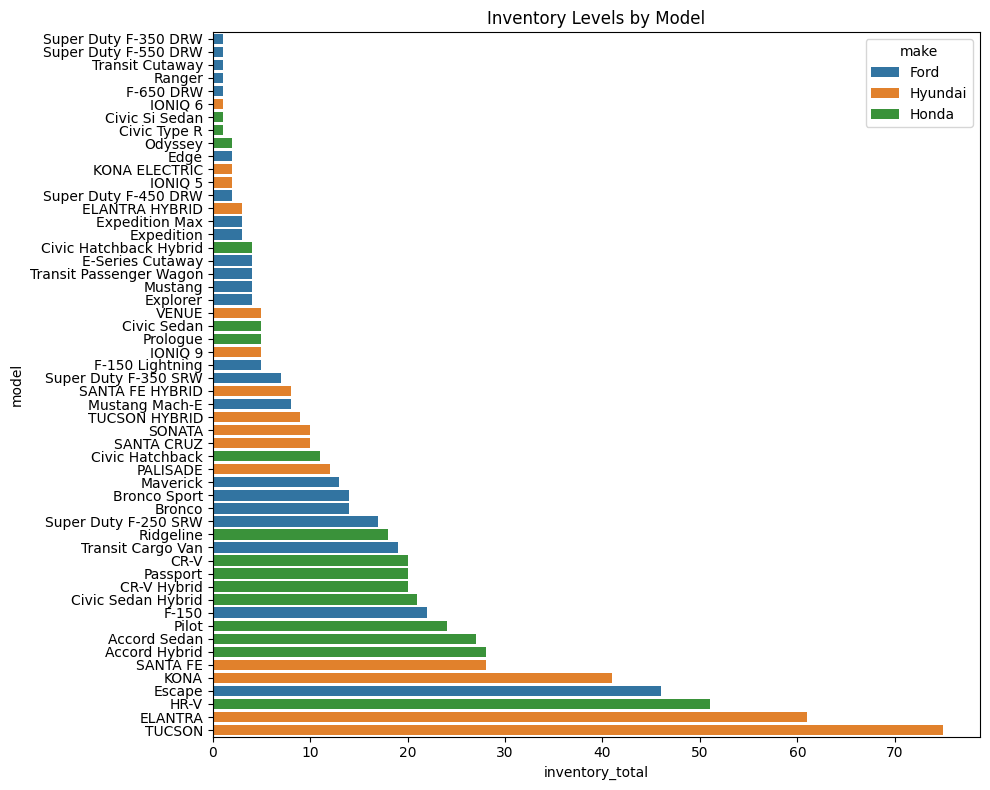

In [16]:
# Vertical bar chart
plt.figure(figsize=(14,6))
sns.barplot(data=inventory_df, x='model', y='inventory_total', hue='make')
plt.title('Inventory Levels by Model')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Horizontal bar chart
plt.figure(figsize=(10,8))
sns.barplot(data=inventory_df.sort_values('inventory_total'), y='model', x='inventory_total', hue='make')
plt.title('Inventory Levels by Model')
plt.tight_layout()
plt.show()

---
## Step 5: Simulate Reorder Logic and Calculate KPIs

In [17]:
# Reorder flag
REORDER_THRESHOLD = 20
inventory_df['reorder_needed'] = inventory_df['inventory_total'] < REORDER_THRESHOLD

# Turnover
inventory_df['avg_daily_sales'] = 30 / inventory_df['avg_days_on_lot']
inventory_df['annual_sales'] = inventory_df['avg_daily_sales'] * 365
inventory_df['inventory_turnover'] = inventory_df['annual_sales'] / inventory_df['inventory_total']

---
## Step 6: Assess Stockout Risk

In [18]:
def assess_stockout_risk(row):
    if row['days_of_supply'] < 5:
         return 'High'
    elif row['days_of_supply'] < 15:
        return 'Medium'
    else:
       	 return 'Low'
    
# apply the function to create the new column
inventory_df['stockout_risk'] = inventory_df.apply(assess_stockout_risk, axis=1)

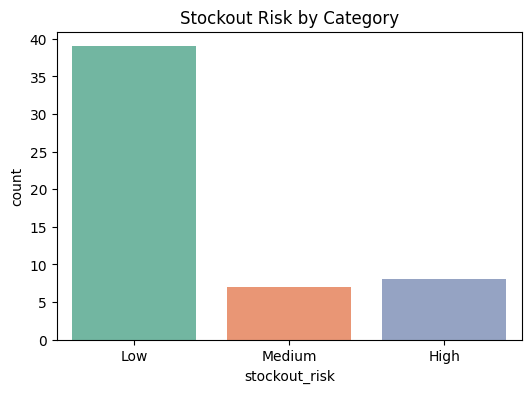

In [19]:
# Visualize risk
plt.figure(figsize=(6,4))
sns.countplot(data=inventory_df, x='stockout_risk', hue='stockout_risk', palette='Set2', legend=False)
plt.title('Stockout Risk by Category')
plt.show()

---
## Step 7: Visualize KPI Relationships

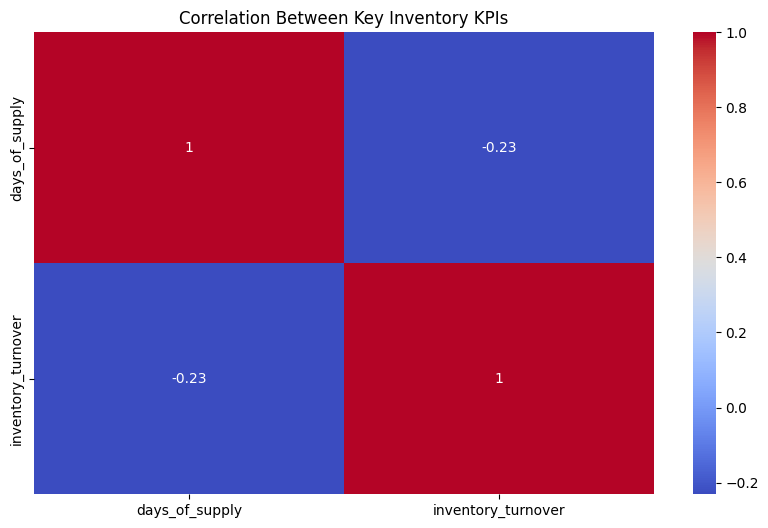

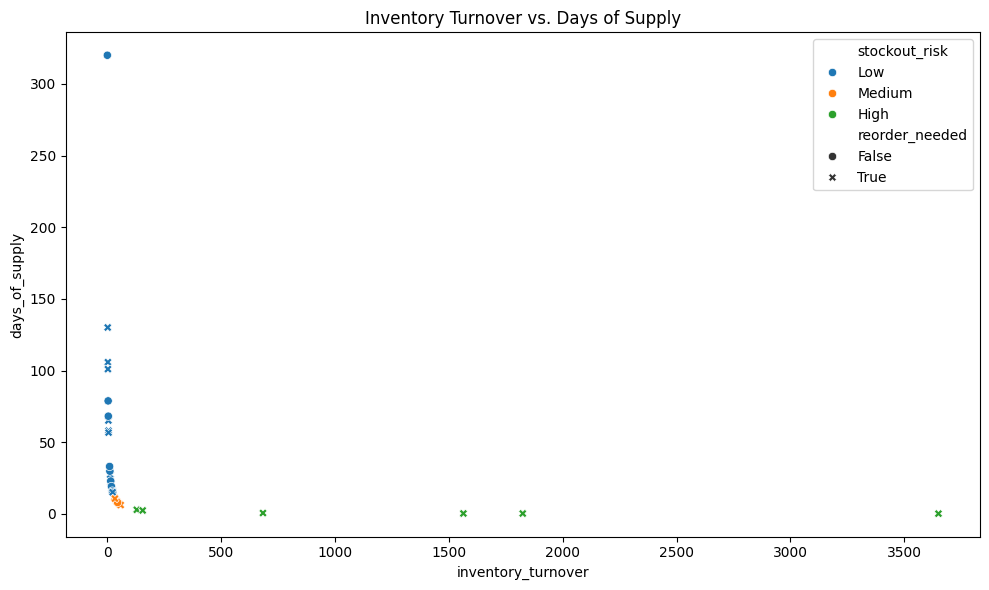

In [20]:
# Heatmap
plt.figure(figsize=(10,6))
sns.heatmap(inventory_df[['days_of_supply', 'inventory_turnover']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Key Inventory KPIs')
plt.show()

# Scatter plot
plt.figure(figsize=(10,6))
sns.scatterplot(data=inventory_df, x='inventory_turnover', y='days_of_supply', hue='stockout_risk', style='reorder_needed')
plt.title('Inventory Turnover vs. Days of Supply')
plt.tight_layout()
plt.show()

---
## Step 8: Forecast Future Inventory Levels

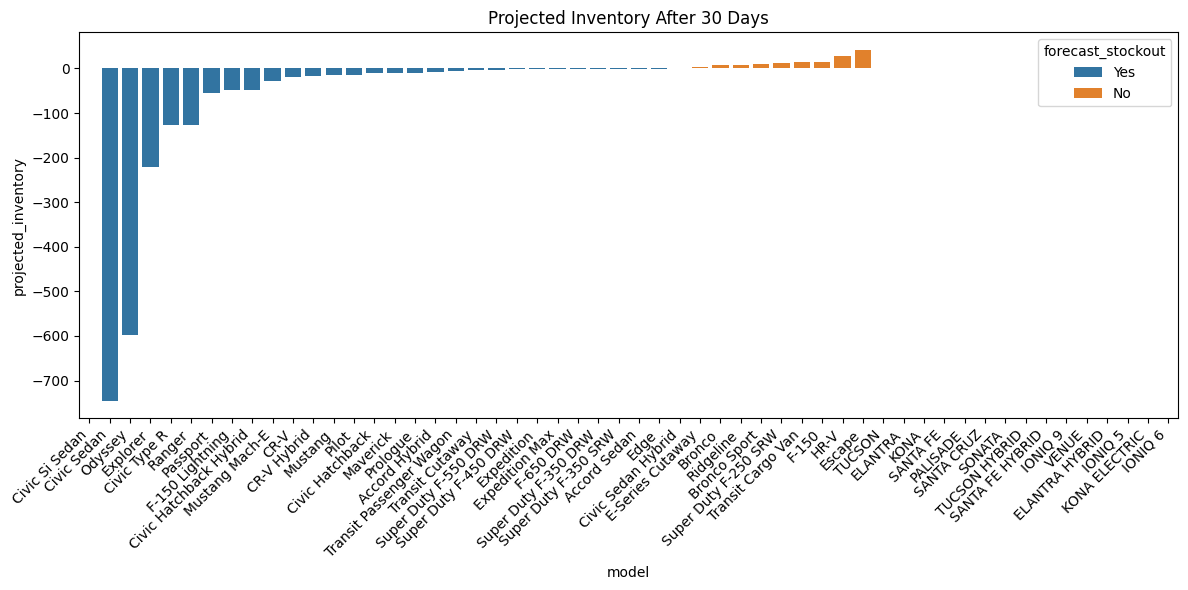

In [21]:
forecast_days = 30
forecast_df = inventory_df.copy()
forecast_df['projected_inventory'] = forecast_df['inventory_total'] - (forecast_df['avg_daily_sales'] * forecast_days)
forecast_df['forecast_stockout'] = forecast_df['projected_inventory'].apply(lambda x: 'Yes' if x <= 0 else 'No')
forecast_df['reorder_recommended'] = forecast_df.apply(
    lambda row: 'Yes' if row['forecast_stockout'] == 'Yes' or row['reorder_needed'] else 'No', axis=1
)

# Visualize forecast
plt.figure(figsize=(12,6))
sns.barplot(data=forecast_df.sort_values('projected_inventory'), x='model', y='projected_inventory', hue='forecast_stockout')
plt.title(f'Projected Inventory After {forecast_days} Days')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

---
## Step 9: Export Final Report

In [22]:
inventory_df.to_excel('Inventory_Health_Report.xlsx', index=False)

---
## Summary & Key Takeaways

This inventory health monitor provides a foundational framework for tracking, analyzing, and forecasting dealership stock. Key insights include:

**Inventory Distribution**  
Certain models dominate inventory, while others are understocked and may require attention.

**Days of Supply**  
Models with low days of supply are at risk of stockouts, especially if demand remains steady.

**Inventory Turnover**  
High turnover models indicate strong sales velocity and efficient inventory flow.

**Stockout Risk**  
Vehicles with low projected inventory and high turnover should be prioritized for reorder.

**Forecasting**  
A 30-day projection reveals which models may run out of stock, enabling proactive planning.

This notebook can be extended with real-time sales data, lead time modeling, and integration into a dashboard for dynamic decision-making.